In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import timm
from torch.autograd import Function
from torchvision import transforms

In [20]:
# Função para calcular Grad-CAM
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradient = None
        self.activation = None

        # Registrar os hooks para capturar a ativação e o gradiente
        self.hook()

    def hook(self):
        # Hook para salvar a ativação
        def save_activation(module, input, output):
            self.activation = output

        # Hook para salvar o gradiente
        def save_gradient(module, grad_input, grad_output):
            self.gradient = grad_output[0]

        # Adicionar hooks na camada alvo
        self.target_layer.register_forward_hook(save_activation)
        self.target_layer.register_backward_hook(save_gradient)

    def generate_cam(self, input_image, target_class=None):
        self.model.zero_grad()
        
        # Realizar a previsão
        output = self.model(input_image)
        
        # Se uma classe de destino for fornecida, use-a; caso contrário, use a classe com maior probabilidade
        if target_class is None:
            target_class = torch.argmax(output)
        
        # Realizar a retropropagação da classe alvo
        self.model.zero_grad()
        output[0, target_class].backward()

        # Obter o gradiente e a ativação da camada alvo
        grad = self.gradient
        activation = self.activation

        # Calcular os pesos do Grad-CAM (global average pooling)
        weights = torch.mean(grad, dim=[1, 2], keepdim=True)
        cam = torch.sum(weights * activation, dim=0)

        # Aplicar ReLU para ter apenas valores positivos (importância)
        cam = F.relu(cam)

        # Redimensionar a saída para o tamanho da entrada
        cam = cam.cpu().detach().numpy()
        cam = cv2.resize(cam, (input_image.size(2), input_image.size(3)))

        # Normalizar entre 0 e 1
        cam -= np.min(cam)
        cam /= np.max(cam)

        return cam

In [21]:
MODEL_PATH = "model/xception_deepfake.pth"

# Configuração do dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o modelo
model = timm.create_model("xception41.tf_in1k", pretrained=False, num_classes=2)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

XceptionAligned(
  (stem): Sequential(
    (0): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
    (1): ConvNormAct(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
    )
  )
  (blocks): Sequential(
    (0): XceptionModule(
      (shortcut): ConvNormAct(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (bn): BatchNormAct2d(
          128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
      )
      (stack): Sequential(
     

In [22]:
# Verificar as camadas do modelo e encontrar uma camada convolucional para o Grad-CAM
# print(model)

# Aqui vamos escolher uma camada convolucional específica, como o último bloco convolucional
# Por exemplo, para a arquitetura Xception, podemos tentar algo como 'model.blocks[-1]'
target_layer = model.blocks[-1]  # Última camada convolucional, ajuste conforme necessário

# Instanciar Grad-CAM
grad_cam = GradCAM(model, target_layer)

In [23]:
# Pré-processamento da imagem (ajuste conforme necessário)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/home/flavio/anaconda3/envs/myenv/lib/python3.12/site-packages/torch/nn/modules/module.py:1352: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


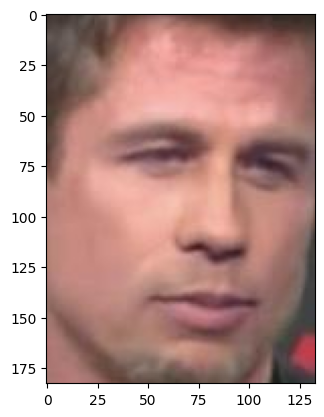

In [ ]:
#full_name = "videos-teste/CELEB-DF/faces/Deepfake/id0_id26_0005/frame_105_face_1.jpg"
full_name = "videos-teste/CELEB-DF/faces/Deepfake/id1_id21_0002/frame_25_face_0.jpg"

# Carregar a imagem da face (ajuste para o seu caso de uso)
image = cv2.imread(full_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

import matplotlib.pyplot as plt
plt.imshow(image)

# Pré-processar a imagem e adicionar uma dimensão de batch
input_image = transform(image).unsqueeze(0).to(device)

# Gerar o Grad-CAM
cam = grad_cam.generate_cam(input_image)

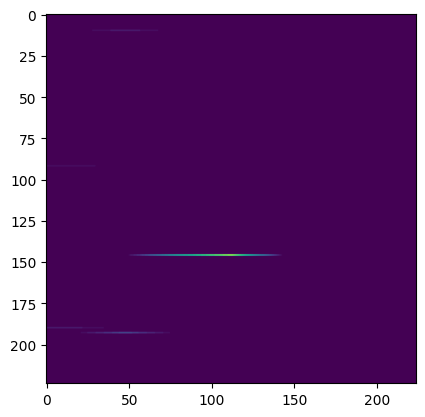

In [46]:
# Converta o Grad-CAM para um formato adequado para applyColorMap
cam = np.uint8(255 * cam)  # Converte o mapa de calor para o intervalo de 0 a 255
cam0 = cam[:, :, 0]  # Seleciona o primeiro canal

plt.imshow(cam0)

#heatmap = cv2.applyColorMap(cam0, cv2.COLORMAP_JET)  # Aplica o colormap



# Redimensione a imagem original para o tamanho desejado
#image_with_heatmap = np.float32(image) / 255
#image_with_heatmap = cv2.resize(image_with_heatmap, (224, 224))

# Superpõe o mapa de calor na imagem original
#superimposed_image = cv2.addWeighted(image_with_heatmap, 0.5, heatmap, 0.5, 0)

# Exibir a imagem com o Grad-CAM
#cv2.imshow('Grad-CAM', superimposed_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [ ]:
# Visualizar o Grad-CAM
# Aplique um mapa de calor ao Grad-CAM

# Converta o Grad-CAM para um formato adequado para applyColorMap
cam = np.uint8(255 * cam)  # Converte o mapa de calor para o intervalo de 0 a 255

cam = np.mean(cam, axis=-1)

if len(cam.shape) == 2:  # Se o Grad-CAM for uma imagem de um único canal
    heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)  # Aplica o colormap
else:
    print("Erro: o Grad-CAM não está no formato esperado.")

# Redimensione a imagem original para o tamanho desejado
image_with_heatmap = np.float32(image) / 255
image_with_heatmap = cv2.resize(image_with_heatmap, (224, 224))

# Superpõe o mapa de calor na imagem original
superimposed_image = cv2.addWeighted(image_with_heatmap, 0.5, heatmap, 0.5, 0)

# Exibir a imagem com o Grad-CAM
cv2.imshow('Grad-CAM', superimposed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

Erro: o Grad-CAM não está no formato esperado.


NameError: name 'heatmap' is not defined

In [ ]:
# Exibir a imagem com o Grad-CAM
cv2.imshow('Grad-CAM', superimposed_image)
cv2.waitKey(0)
cv2.destroyAllWindows()